In [106]:
#Yuyang Gong's hw3
#fall2023 cs4962 ML and Optimization, RPI
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import load_svmlight_file

###### Subgradient Descent with $l_2$ Regularization: $$f(w,b) = \frac{1}{n}\sum_{i=1}^n (1-y_i(<w,x_i>+b))_+ + \frac{\lambda}{2}\lVert w\rVert_2^2$$ Here $x_i\in\mathbb{R}^d$ and $y_i\in\{-1,1\}$ for $i=1,\dots,n$.

Subdifferential of $f$ is given by: $$\frac{\partial}{\partial(w,b)} f(w,b) = \frac{1}{n}\sum_{i=1}^n y_ix_i\left(\left\{\begin{array}{ll} -1 & \text{if } y_i(<w,x_i>+b)<1\\  [-1,0] & \text{if } y_i(<w,x_i>+b)\neq 1 \\ 0 &\text{if } y_i(<w,x_i>+b)> 1 \end{array}\right. \right)+ \lambda w_i$$

In [108]:
# implement the subgradient descent algorithm
def subgradloss(x, y, w_b):
    w, b = w_b[:-1], w_b[-1]
    margin = y * (np.dot(w, x) + b)
    if margin < 1:
        return -y * np.append(x, 1)
    else:
        return np.zeros_like(np.append(x, 1))

def subgradreg(x, y, w_b):
    w = w_b[:-1]
    return np.append(w, 0)

def sgdmethod(X, y, subgradloss, subgradreg, regparam, w1, T, a, m):
    n, _ = X.shape
    w = w1
    w_history = [w1]

    for t in range(T):
        for i in range(n//m): # with T = epoch * n/m
            idx = i*m
            X_batch = X[idx:idx+m]
            y_batch = y[idx:idx+m]
            idx = np.random.choice(n, m)
            X_batch = X[idx]
            y_batch = y[idx]
            # Compute the subgradient of the loss and regularizer
            g_loss = np.mean([subgradloss(X_batch[i], y_batch[i], w) for i in range(m)], axis=0)
            g_reg = subgradreg(X_batch, y_batch, w)

            # Update the parameter vector
            alpha_t = 1.0 / (1.0 + a * t)
            w = w - alpha_t * (g_loss + regparam * g_reg)
            
        # Store the updated parameter vector every end of epoch
        w_history.append(w)

    return w_history



In [109]:
# Load data
X_train, y_train = load_svmlight_file("a9a.txt")
X_test, y_test = load_svmlight_file("a9a.t")

# remove the last column of X_train
X_train = X_train[:,:-1]

# preprocess the data
scaler = preprocessing.StandardScaler().fit(X_train.toarray())
X_train = scaler.transform(X_train.toarray())
X_test = scaler.transform(X_test.toarray())

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(32561, 122)
(32561,)
(16281, 122)
(16281,)


In [110]:
# Set the parameters
regparam = 1/len(y_train) # lambda = 1/n_train
w1 = np.zeros(X_train.shape[1]+1) #combined with bias
T = 100 # number of iterations = 100
a = 1e-4 # step size
m = len(y_train) #batch size = n_train

# Run the subgradient descent algorithm
parameter_sequence = sgdmethod(X_train, y_train, subgradloss, subgradreg, regparam, w1, T, a, m)


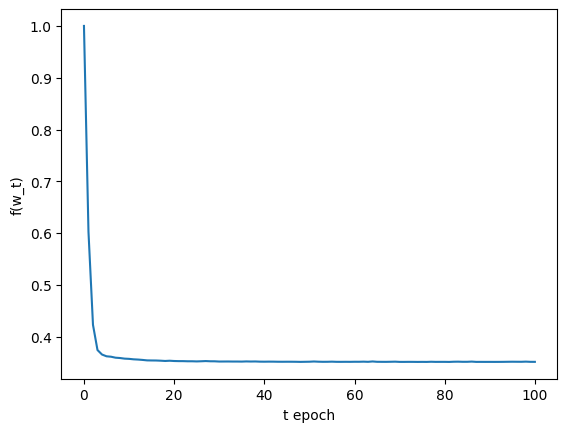

In [111]:
# plot f(w_t) v.r.t. t
def f(w_b, X, y, regparam):
    w, b = w_b[:-1], w_b[-1]
    return np.mean(np.maximum(1 - y * (np.dot(X, w) + b), 0)) + regparam * np.linalg.norm(w)**2

f_values = [f(w_b, X_train, y_train, regparam) for w_b in parameter_sequence]
plt.plot(f_values)
plt.xlabel('t epoch')
plt.ylabel('f(w_t)')
plt.show()


In [112]:
# choose a for minibatch size m = 1
m = 1
a = 1e-8
parameter_sequence_m1 = sgdmethod(X_train, y_train, subgradloss, subgradreg, regparam, w1, T, a, m)

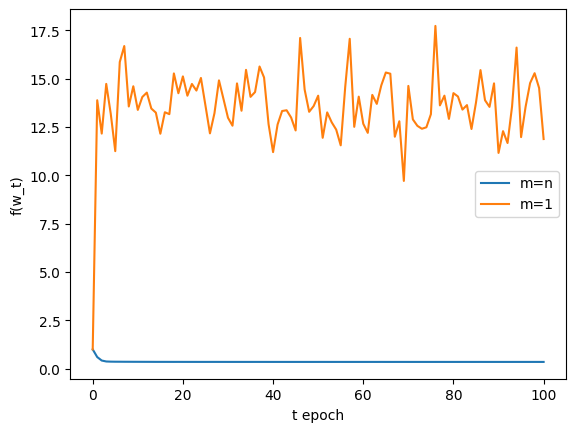

In [113]:
# plot both f(w_t) v.r.t. t
f_values_m1 = [f(w_b, X_train, y_train, regparam) for w_b in parameter_sequence_m1]
plt.plot(f_values, label='m=n')
plt.plot(f_values_m1, label='m=1')
plt.xlabel('t epoch')
plt.ylabel('f(w_t)')
plt.legend()
plt.show()


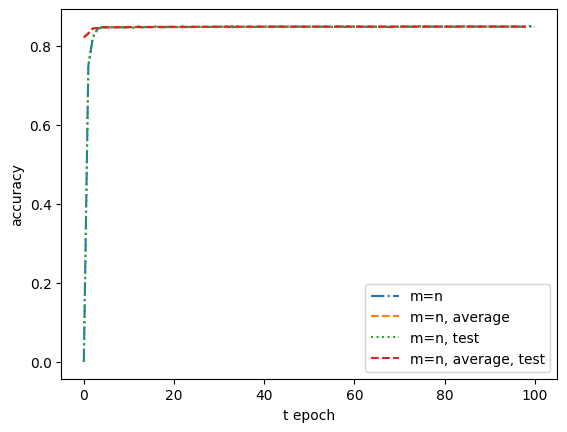

In [114]:
# plot on the same graph the accuracy on:
    # (1) the training data
    # (2) for each t>=2, model with parameter 
    #   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the training data
    # (3) the test data
    # (4) for each t>=2, model with parameter 1
    #   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the test data
def accuracy(w_b, X, y):
    w, b = w_b[:-1], w_b[-1]
    return np.mean(np.sign(np.dot(X, w) + b) == y)

# (1) the training data
accuracy_values = [accuracy(w_b, X_train, y_train) for w_b in parameter_sequence]
# (2) for each t>=2, model with parameter
#   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the training data
accuracy_values_ave = [np.mean(accuracy_values[t//2+1:t+1]) for t in range(2, len(accuracy_values))]
# (3) the test data
accuracy_values_test = [accuracy(w_b, X_test, y_test) for w_b in parameter_sequence]
# (4) for each t>=2, model with parameter
#   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the test data
accuracy_values_test_ave = [np.mean(accuracy_values_test[t//2+1:t+1]) for t in range(2, len(accuracy_values_test))]
# plot
plt.plot(accuracy_values, label='m=n', linestyle='-.')
plt.plot(accuracy_values_ave, label='m=n, average', linestyle='--')
plt.plot(accuracy_values_test, label='m=n, test', linestyle=':')
plt.plot(accuracy_values_test_ave, label='m=n, average, test', linestyle='--')
plt.xlabel('t epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()




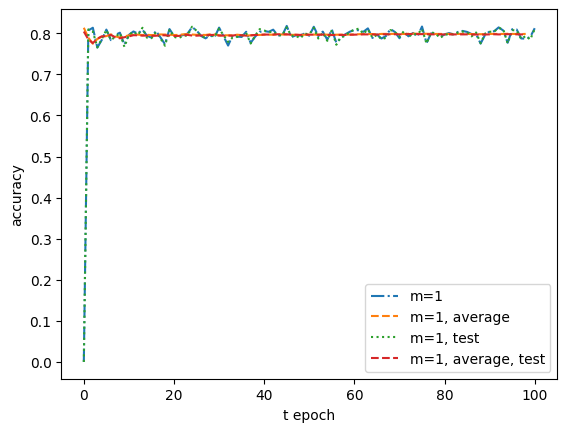

In [115]:
# separate the m=1 case# (1) the training data
accuracy_values_m1 = [accuracy(w_b, X_train, y_train) for w_b in parameter_sequence_m1]
# (2) for each t>=2, model with parameter
#   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the training data
accuracy_values_ave_m1 = [np.mean(accuracy_values_m1[t//2+1:t+1]) for t in range(2, len(accuracy_values_m1))]
# (3) the test data
accuracy_values_test_m1 = [accuracy(w_b, X_test, y_test) for w_b in parameter_sequence_m1]
# (4) for each t>=2, model with parameter
#   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the test data
accuracy_values_test_ave_m1 = [np.mean(accuracy_values_test_m1[t//2+1:t+1]) for t in range(2, len(accuracy_values_test_m1))]
# plot
plt.plot(accuracy_values_m1, label='m=1', linestyle='-.')
plt.plot(accuracy_values_ave_m1, label='m=1, average', linestyle='--')
plt.plot(accuracy_values_test_m1, label='m=1, test', linestyle=':')
plt.plot(accuracy_values_test_ave_m1, label='m=1, average, test', linestyle='--')
plt.xlabel('t epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [116]:
# the highest accuracy on the four plots of both m=n and m=1
# m=n
# (1) the training data
print('m=n: training data, highest accuracy: ', max(accuracy_values))
# (2) for each t>=2, model with parameter
#   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the training data
print('m=n: training data average, highest accuracy: ', max(accuracy_values_ave))
# (3) the test data
print('m=n: test data, highest accuracy: ', max(accuracy_values_test))
# (4) for each t>=2, model with parameter
#   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the test data
print('m=n: test data average, highest accuracy: ', max(accuracy_values_test_ave))

# m=1
# (1) the training data
print('m=1: training data, highest accuracy: ', max(accuracy_values_m1))
# (2) for each t>=2, model with parameter
#   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the training data
print('m=1: training data average, highest accuracy: ', max(accuracy_values_ave_m1))
# (3) the test data
print('m=1: test data, highest accuracy: ', max(accuracy_values_test_m1))
# (4) for each t>=2, model with parameter
#   1/(t-t//2+1)\sum_{i=t//2+1}^t w_i on the test data
print('m=1: test data average, highest accuracy: ', max(accuracy_values_test_ave_m1))


m=n: training data, highest accuracy:  0.8498817603881945
m=n: training data average, highest accuracy:  0.8491293264948866
m=n: test data, highest accuracy:  0.8511147963884282
m=n: test data average, highest accuracy:  0.8495915484306861
m=1: training data, highest accuracy:  0.8178802862319954
m=1: training data average, highest accuracy:  0.8134271060471115
m=1: test data, highest accuracy:  0.8159818192985688
m=1: test data average, highest accuracy:  0.8042503531724096


We found that: 
* The test accuracy is 0.8511 for subgradient decent, and 0.8160 for stochastic subgradient decent.
* The average test accuracy is 0.8496 for subgradient decent, and 0.8043 for stochastic subgradient decent.

The stochastic can calculate faster, but the test accuracy is lower than subgradient decent. The averaging make the line smoother.

## 2.
###### Given $g\in\partial f(x_t)$: $$ x_{t+1} = \text{arg}\min_{u\in C}f(x_t) + <g,u-x_t> + \frac{1}{2\alpha_t}\lVert (u-x_t)\rVert_2^2$$

$f(x_t) + <g,u-x_t>$ is the linear approximation of $f$ at $x_t$, where $g$ is a subgradient of $f$ at $x_t$, which will go to the direction of the steepest descent. The norm $ \frac{1}{2\alpha_t}\lVert (u-x_t)\rVert_2^2$ is a quadratic regularizer, which will limit the step size and make the line smoother.

###### Similar unconstrained optimization problem with proximal regularizer with a quadratic with Hessain $P_t\geq 0$: $$x_{t+1} = \text{arg}\min_{u}f(x_t) + <g,u-x_t> + \frac{1}{2\alpha_t}\lVert P_t^{\frac{1}{2}}(u-x_t)\rVert_2^2$$

The optimality conditions for both the constrained and unconstrained optimization problems are the same because they both minimize the same objective function, which is a linear approximation of $f$ at $x_t$ plus a quadratic regularization term. 

For the linear approximation, this gradient is just $g$, a subgradient of $f$ at $x_t$. For the regularization term, this gradient is $\frac{1}{\alpha_t}P_t^{\frac{1}{2}}(u-x_t)$.

The second unconstrained objective can be transformed into the first constrained objective by setting $C = \{u: P_t^{\frac{1}{2}}(u-x_t) = 1\}$.

**Check the objectives are same as Newton's method and AdaGrad**

To find a closed form expression for $x_{t+1}$, we can set the gradient of the above expression with respect to $u$ equal to zero. This gives us:

$$\nabla_u [f(x_t) + <g,u-x_t> + \frac{1}{2\alpha_t}\lVert P_t^{\frac{1}{2}}(u-x_t)\rVert_2^2] = 0$$

Solving the above equation for $u$, we get:

\begin{align*}
    \nabla_u [f(x_t) + <g,u-x_t> + \frac{1}{2\alpha_t}\lVert P_t^{\frac{1}{2}}(u-x_t)\rVert_2^2] &= 0\\
    \nabla f(x_t) + g + \frac{1}{\alpha_t}P_t^{\frac{1}{2}}(u-x_t) &= 0\\ 
    \frac{1}{\alpha_t}P_t^{\frac{1}{2}}(u-x_t) &= -\nabla f(x_t) - g\\
    P_t^{\frac{1}{2}}(u-x_t) &= -\alpha_t(\nabla f(x_t) + g)\\
    u-x_t &= -\alpha_t P_t^{-\frac{1}{2}}(\nabla f(x_t) + g)\\
    u &= x_t - \alpha_t P_t^{-\frac{1}{2}}(\nabla f(x_t) + g)
\end{align*}
For $x_{t+1}$ we can just set $\nabla f(x_t)=0$, and have:
$$x_{t+1} = x_t - \alpha_t P_t^{-\frac{1}{2}} g$$

Now, let's see how this general form encompasses both Newton's method and AdaGrad:

1. **Newton's Method**: In Newton's method, we have $\alpha_t = 1$, and $P_t$ is the Hessian matrix of $f$ at $x_t$, denoted by $H_t$. So, the update rule using the optimal local quadratic approximation becomes: 

    $$x_{t+1} = x_t - H_t^{-1} g$$

    So let $H_t = P_t^{\frac{1}{2}}$ and $\alpha_t = 1$, and we get the Newton's method update rule.

2. **AdaGrad**: In AdaGrad, we have:

    $$x_{t+1} = x_t - \alpha(D_t+\epsilon I)^{-1/2}g$$

    where $D_t$ is a diagonal matrix with $D_{t,ii} = \sum_{i=1}^t g_{t,i}^2$, and $\epsilon$ is a small constant to avoid division by zero. When setting $\alpha_t = \alpha$, $P_t = D_t+\epsilon I$, we get the AdaGrad update rule.

So, by choosing $g$, $\alpha_t$, and $P_t$ appropriately, we can indeed view both Newton's method and AdaGrad as instances of this general optimization problem.